# Table of SEA anomaly anlysis for CMIP6 Historical model runs
- opens all the CMIP6 historical model run files with data on precipitation pr and surface temperature tas
- calculates monthly anomalies (based on 5-yr climatology) for 4 spatial regions (global, SH, Aus, E Aus) and 5 eruptions
- calculates percentiles (10, 90) to show model spread
- examines the difference between different models and eruptions by looking at the sign of the anomaly at 3 time periods (0-6 months, 0-12 months and 0-24 months post-eruption)
- shows anomaly results in a table 


In [9]:
import xarray as xr, matplotlib.pyplot as plt
from importlib import reload # need to use this if I edit a function file
import os
import numpy as np
import pandas as pd
import cartopy.crs as ccrs # to add in continents and change map projections 
from matplotlib.colors import LinearSegmentedColormap # to change colour bar????
import seaborn as sns
import dask.diagnostics # dask allows you to check how long something is taking to load

In [10]:
# import custom functions
import sys 
sys.path.append('/home/563/kb6999/Functions') # use this if the function file is in a different directory to the notebook

import frequently_used_functions as func
import plotting_functions as fplot
import model_functions as funcM
import reanalysis_functions as funcR

In [11]:
# define function to check if model has a postive or negative anomaly
def anomaly_check(dataset, start_date, end_date):
    """ Check if each model has a postive or negative anomaly
        
        Args:
        dataset (xarray): data set of climate variable(s)
        start_date (date_str): start date
        end_date (date_str): end date 
    """
    import xarray as xr, numpy as np
    
    # select out the desired time period and then take the mean over the time period
    ds_slice = dataset.sel(time=slice(f'{start_date}',f'{end_date}'))
    ds_mean = ds_slice.mean(dim='time')
                                      
    # replace the value with + for positive anomaly and - for negative anomaly 
    ds_mean['tas'] = xr.where(ds_mean.tas > 0, 1, 0)
    ds_mean['pr'] = xr.where(ds_mean.pr > 0, 1, 0)
    
    return ds_mean


In [12]:

# define function to plot table of models with positive and negative anomalies colour coded input ds.var
def mod_check_plot2(dataset1, dataset2, dataset3, colour_ar, ax=None):
    """Create a table showing if anomalies are postive or negative for each model, each eruption at 3 averaged time periods (data for each time is in each of the three data sets).  Models as rows and eruptions as columns.    
    Return the axis.  
    
    Args:
        dataset1 (xarray): xarray of table values for first time period (use output from function "anomaly_check")
        dataset2 (xarray): xarray of table values for first time period (use output from function "anomaly_check")
        dataset3 (xarray): xarray of table values for first time period (use output from function "anomaly_check")
        colour_ar (dict): dictionary of colour strings 
        ax (axis): axis
    """
    import xarray as xr, numpy as np, matplotlib.pyplot as plt
    
    # checking if an axis has been defined and if not creates one with function "get current axes"
    if ax is None:
        ax = plt.gca() 
    ax.axis('off')
    
    # sum the datsets so I can use the sum to set the cell colour
    dataset = dataset1 + dataset2 + dataset3
    
    # set the data for rows and columns 
    rows = dataset.model.data
    cols = dataset.volcano.data
    
    # convert to data array (rather than xarray)
    ds = dataset.values
    ds1 = dataset1.values
    ds2 = dataset2.values
    ds3 = dataset3.values
    
    # change the axes so that rows correspond to each model and cols correspond to volcanoes
    ds = np.swapaxes(ds,0,1)
    ds1 = np.swapaxes(ds1,0,1)
    ds2 = np.swapaxes(ds2,0,1)
    ds3 = np.swapaxes(ds3,0,1)
    
    # change to postivie and negative sign correspponding to sign of anomaly
    ds1 = xr.where(ds1 == 1, '+ ', '-   ')
    ds2 = xr.where(ds2 == 1, '+ ', '-   ')
    ds3 = xr.where(ds3 == 1, '+ ', '-   ')

    # set the cell text to +/- at each time point
    cell_text = []
    for i, val in enumerate(ds1):
        row_text = []
        for j, val2 in enumerate(val):
            text = ds1[i,j] + ds2[i,j] + ds3[i,j]
            row_text.append(text)
        cell_text.append(row_text)
        
    # make an array of colour names 
    #colour_ar = np.array(['royalblue', 'lightblue', 'lightcoral', 'crimson'])
    
    # Use the data values as indices into the colour name array
    colours = colour_ar[ds]
    
    # make table
    tab = ax.table(cellText = cell_text, cellColours= colours, colLabels=cols, rowLabels=rows, loc='upper center',cellLoc='center')

    tab.set_fontsize(14)

    # ways to change the colour of a specific cell
    # tab[0,0].set_facecolor('red')
    # table_props = table.properties()
    # table_cells = table_props['children'] # access data in cells, 'children' is a code word
    
    return(ax)


In [13]:
# use this to reload the function file if I make any edits to it
func = reload(func) 

In [14]:
# store each section of the directory as a string
institution_dir = '/g/data/lp01/CMIP6/CMIP/'
tas_dir = '/historical/r1i1p1f1/Amon/tas/gr1.5/'
pr_dir = '/historical/r1i1p1f1/Amon/pr/gr1.5/'
print(institution_dir, tas_dir, pr_dir)

/g/data/lp01/CMIP6/CMIP/ /historical/r1i1p1f1/Amon/tas/gr1.5/ /historical/r1i1p1f1/Amon/pr/gr1.5/


In [15]:
models_tas = funcM.read_models(institution_dir, tas_dir, '1850-01','2015-01')

49 model paths found and loaded into the dictionary "models"
Path for MCM-UA-1-0 does not exist
Model MPI-ESM1-2-HR has different time so is now removed
Model E3SM-1-0 has different time so is now removed
Model EC-Earth3-Veg has different time so is now removed
45 models have been successfully loaded into an xarray


In [16]:
models_pr = funcM.read_models(institution_dir, pr_dir, '1850-01','2015-01')

48 model paths found and loaded into the dictionary "models"
Path for MCM-UA-1-0 does not exist
47 models have been successfully loaded into an xarray


In [17]:
# make sure the models are the same for both vairables
# delete the height from the models_tas array (if it hasn't been deleted already)
if 'height' in models_tas:
    del models_tas['height']
# delete models that aren't common between variables
models_tas = models_tas.where(models_tas.model.isin(models_pr.model), drop = True)
models_pr = models_pr.where(models_pr.model.isin(models_tas.model), drop = True)
#chekc that the models are the same for both variables and if so print True
models_tas.model.equals(models_pr.model)

True

In [18]:
# combine precipitation and temperature into one dataset
models = xr.Dataset({'tas': models_tas.tas, 'pr': models_pr.pr})
# change the pr units
models['pr'] = models.pr*86400
models

,Array,Chunk
Bytes,10.04 GB,1.38 MB
Shape,"(44, 1980, 120, 240)","(1, 12, 120, 240)"
Count,36929 Tasks,7260 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,20.07 GB,2.76 MB
Shape,"(44, 1980, 120, 240)","(1, 12, 120, 240)"
Count,45181 Tasks,7260 Chunks
Type,float64,numpy.ndarray


In [19]:
# get rid of models with issues
models = models.drop_sel(model=['CIESM'])

In [20]:
# sort models alphabetically and prints final model list
models = models.sortby('model')
print('The following', len(models.model.data), 'models will be used in all subsequent calculations: \n')
print(models.model.data)

The following 43 models will be used in all subsequent calculations: 

['ACCESS-CM2' 'ACCESS-ESM1-5' 'AWI-CM-1-1-MR' 'AWI-ESM-1-1-LR'
 'BCC-CSM2-MR' 'BCC-ESM1' 'CAMS-CSM1-0' 'CAS-ESM2-0' 'CESM2' 'CESM2-FV2'
 'CESM2-WACCM' 'CESM2-WACCM-FV2' 'CMCC-CM2-HR4' 'CMCC-CM2-SR5' 'CanESM5'
 'E3SM-1-1' 'E3SM-1-1-ECA' 'EC-Earth3' 'EC-Earth3-AerChem'
 'EC-Earth3-Veg-LR' 'FGOALS-f3-L' 'FGOALS-g3' 'FIO-ESM-2-0' 'GFDL-CM4'
 'GFDL-ESM4' 'GISS-E2-1-G' 'GISS-E2-1-G-CC' 'GISS-E2-1-H' 'IITM-ESM'
 'INM-CM4-8' 'INM-CM5-0' 'IPSL-CM6A-LR' 'KACE-1-0-G' 'MIROC6'
 'MPI-ESM-1-2-HAM' 'MPI-ESM1-2-LR' 'MRI-ESM2-0' 'NESM3' 'NorCPM1'
 'NorESM2-LM' 'NorESM2-MM' 'SAM0-UNICON' 'TaiESM1']


Right now I have all the models stored in one array so from hereafter I can calculate anomalies etc.  
## Select out regions and eruption dates

In [21]:
# area weighting 
models_w = models*np.cos(models.lat*(np.pi/180))

In [23]:
# eruption date
e_date = pd.to_datetime(['1883-08','1902-10', '1963-03', '1982-04', '1991-06'])
# e_pre5yrs = ['1878-08','1897-10', '1958-03', '1977-04', '1986-06']
# e_pre3mon = ['1883-05','1902-7', '1962-12', '1982-01', '1991-03']
# e_post5yrs = ['1888-08','1907-10', '1968-03', '1987-04', '1996-06']

In [24]:
# save arrays of times relative to each eruption
e_pre5yrs = e_date - 60 * pd.offsets.MonthBegin()
e_pre3mon = e_date - 3 * pd.offsets.MonthBegin()
e_post5yrs = e_date + 61 * pd.offsets.MonthBegin()

In [25]:
print(e_pre5yrs[1], e_pre3mon[0], e_post5yrs)

1897-10-01 00:00:00 1883-05-01 00:00:00 DatetimeIndex(['1888-09-01', '1907-11-01', '1968-04-01', '1987-05-01',
               '1996-07-01'],
              dtype='datetime64[ns]', freq=None)


In [26]:
# eruption names
volcanoes = ['Krakatau', 'Santa Maria','Agung','El Chichon', 'Pinatubo']

In [27]:
# select out hte 10 year time frame around each eruption (5yrs before and after)
# tas
Krakatau = models_w.sel(time = slice(e_pre5yrs[0], e_post5yrs[0]))
SantaMaria = models_w.sel(time = slice(e_pre5yrs[1], e_post5yrs[1]))
Agung = models_w.sel(time = slice(e_pre5yrs[2], e_post5yrs[2]))
ElChicon = models_w.sel(time = slice(e_pre5yrs[3], e_post5yrs[3]))
Pinatubo = models_w.sel(time = slice(e_pre5yrs[4], e_post5yrs[4]))

## Anomalies 

In [28]:
# use functions to calculate the monthly anomalies for the globe
K_mon_anom_Glob = func.monthly_anomaly(Krakatau, e_pre5yrs[0], e_pre3mon[0])
S_mon_anom_Glob = func.monthly_anomaly(SantaMaria, e_pre5yrs[1], e_pre3mon[1])
A_mon_anom_Glob = func.monthly_anomaly(Agung, e_pre5yrs[2], e_pre3mon[2])
E_mon_anom_Glob = func.monthly_anomaly(ElChicon, e_pre5yrs[3], e_pre3mon[3])
P_mon_anom_Glob = func.monthly_anomaly(Pinatubo, e_pre5yrs[4], e_pre3mon[4])

In [29]:
# store all eruptions in one array
composite_mon_Glob = funcM.reset_time(K_mon_anom_Glob, S_mon_anom_Glob, A_mon_anom_Glob, E_mon_anom_Glob, P_mon_anom_Glob, volcanoes)

In [30]:
# import land fraction data
landfrac_ds = xr.open_dataset('/home/563/kb6999/Models/landfraction_file_grid1.5.nc')
landmask = landfrac_ds.mean(dim='time')

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.10/lib/python3.8/site-packages/xarray/coding/times.py:83: SerializationWarning: Ambiguous reference date string: 1-01-01 01:00:00. The first value is assumed to be the year hence will be padded with zeros to remove the ambiguity (the padded reference date string is: 0001-01-01 01:00:00). To remove this message, remove the ambiguity by padding your reference date strings with zeros.
  warnings.warn(warning_msg, SerializationWarning)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.10/lib/python3.8/site-packages/xarray/coding/times.py:463: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.10/lib/python3.8/site-packages/numpy/core/_asarray.py:83: SerializationWarning: Unable to decode time axi

In [31]:
# select out each region
composite_mon_SH = composite_mon_Glob.sel(lat=slice(-90,0))
composite_mon_Aus = composite_mon_Glob.sel(lat=slice(-50,-10), lon=slice(110,160)).where(landmask.data==1, drop=True)
composite_mon_EA = composite_mon_Glob.sel(lat=slice(-50,-10), lon=slice(140,155)).where(landmask.data==1, drop=True)

## Multi-model mean and percentiles

In [32]:
# calculate the monthly model mean for monthly anomalies
composite_mmm_Glob = composite_mon_Glob.mean(dim='model').mean(dim=('lat','lon'))
composite_mmm_SH = composite_mon_SH.mean(dim='model').mean(dim=('lat','lon'))
composite_mmm_Aus = composite_mon_Aus.mean(dim='model').mean(dim=('lat','lon'))
composite_mmm_EA = composite_mon_EA.mean(dim='model').mean(dim=('lat','lon'))

In [33]:
# calcuate the lat lon mean (llm)
composite_llm_Glob = composite_mon_Glob.mean(dim=('lat','lon'))
composite_llm_SH = composite_mon_SH.mean(dim=('lat','lon'))
composite_llm_Aus = composite_mon_Aus.mean(dim=('lat','lon'))
composite_llm_EA = composite_mon_EA.mean(dim=('lat','lon'))

In [34]:
# calculate percentile
# 10th percentile
p10_Glob = composite_llm_Glob.chunk({'model': -1,'volcano': -1}).quantile(0.1, dim=['model', 'volcano'])
p10_SH = composite_llm_SH.chunk({'model': -1,'volcano': -1}).quantile(0.1, dim=['model', 'volcano'])
p10_Aus = composite_llm_Aus.chunk({'model': -1,'volcano': -1}).quantile(0.1, dim=['model', 'volcano'])
p10_EA = composite_llm_EA.chunk({'model': -1,'volcano': -1}).quantile(0.1, dim=['model', 'volcano'])

# 90th percentile
p90_Glob = composite_llm_Glob.chunk({'model': -1,'volcano': -1}).quantile(0.9, dim=['model', 'volcano'])
p90_SH = composite_llm_SH.chunk({'model': -1,'volcano': -1}).quantile(0.9, dim=['model', 'volcano'])
p90_Aus = composite_llm_Aus.chunk({'model': -1,'volcano': -1}).quantile(0.9, dim=['model', 'volcano'])
p90_EA = composite_llm_EA.chunk({'model': -1,'volcano': -1}).quantile(0.9, dim=['model', 'volcano'])

In [35]:
# take the composite over all volcanoes
V_composite_mmm_Glob = composite_mmm_Glob.mean(dim='volcano')
V_composite_mmm_SH = composite_mmm_SH.mean(dim='volcano')
V_composite_mmm_Aus = composite_mmm_Aus.mean(dim='volcano')
V_composite_mmm_EA = composite_mmm_EA.mean(dim='volcano')

In [36]:
# # calculate standard deviation
# std_Glob = func.std_bounds_MV(composite_llm_Glob, V_composite_mmm_Glob)
# std_SH = func.std_bounds_MV(composite_llm_SH, V_composite_mmm_SH)
# std_Aus = func.std_bounds_MV(composite_llm_Aus, V_composite_mmm_Aus)
# std_EA = func.std_bounds_MV(composite_llm_EA, V_composite_mmm_EA)

## Check which models have negative anomalies

In [37]:
# use function to check anomalies for each region after 6 months
model_check_6mon_Glob = anomaly_check(composite_llm_Glob, 0, 6)
model_check_6mon_SH = anomaly_check(composite_llm_SH, 0, 6)
model_check_6mon_Aus = anomaly_check(composite_llm_Aus, 0, 6)
model_check_6mon_EA = anomaly_check(composite_llm_EA, 0, 6)


In [38]:
# use function to check anomalies for each region after 12 months
model_check_12mon_Glob = anomaly_check(composite_llm_Glob, 0, 12)
model_check_12mon_SH = anomaly_check(composite_llm_SH, 0, 12)
model_check_12mon_Aus = anomaly_check(composite_llm_Aus, 0, 12)
model_check_12mon_EA = anomaly_check(composite_llm_EA, 0, 12)

In [39]:
# use function to check anomalies for each region after 24 months
model_check_24mon_Glob = anomaly_check(composite_llm_Glob, 0, 24)
model_check_24mon_SH = anomaly_check(composite_llm_SH, 0, 24)
model_check_24mon_Aus = anomaly_check(composite_llm_Aus, 0, 24)
model_check_24mon_EA = anomaly_check(composite_llm_EA, 0, 24)

In [41]:
# set the colour scale for tables 
colours_tas = np.array(['royalblue', 'lightblue', 'lightcoral', 'crimson'])
colours_pr = np.array(['chocolate', 'goldenrod', 'mediumaquamarine', 'darkcyan'])
# colours_pr2 = np.array(['saddlebrown', 'peru', 'lightgreen', 'g'])
# colours_pr3 = np.array(['chocolate', 'goldenrod', 'lightgreen', 'g'])

### Figures are now saved as pdfs so the tables are interactive (ie you can copy all the data from tables). 

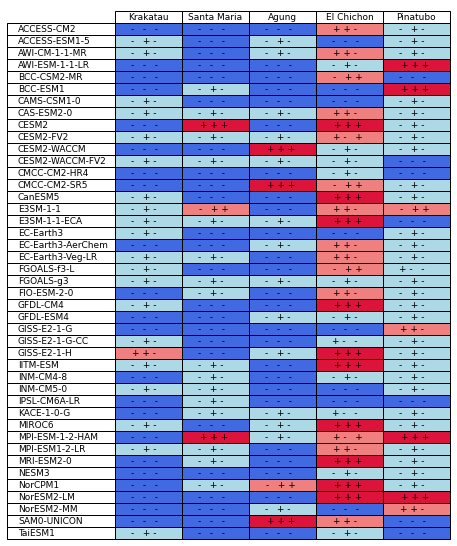

In [42]:
# produce table showing which models have positive and negative anomalies 6,12,24 months after the eruption for globe
fig, axes = plt.subplots(1)

mod_check_plot2(model_check_6mon_Glob.tas, model_check_12mon_Glob.tas, model_check_24mon_Glob.tas, colours_tas, ax=axes)

plt.savefig('model_table_tas_Glob.pdf', dpi=300, bbox_inches='tight')

## bbox_inches='tight' removes all white space around the figure and ensures axes etc are not cut off in the saved plot
# could also use fig.tight_layout()

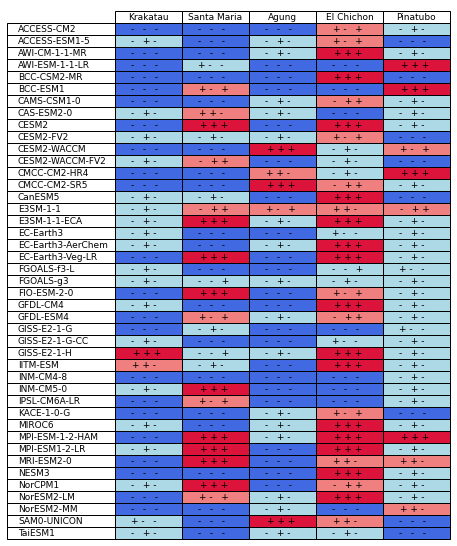

In [43]:
# produce table showing which models have positive and negative anomalies  6,12,24 months after the eruption for SH
fig, axes = plt.subplots(1)

mod_check_plot2(model_check_6mon_SH.tas, model_check_12mon_SH.tas, model_check_24mon_SH.tas, colours_tas, ax=axes)

plt.savefig('model_table_tas_SH.pdf', dpi=300, bbox_inches='tight')

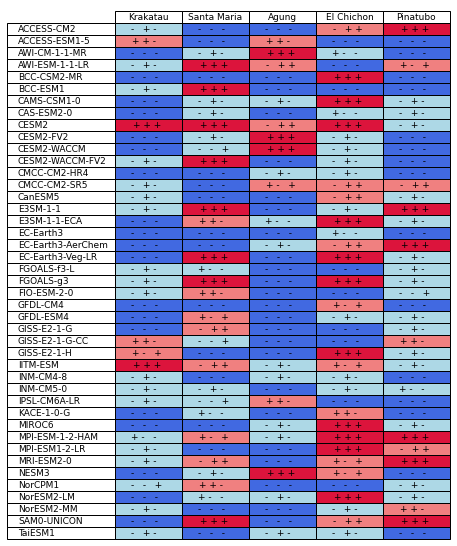

In [44]:
# produce table showing which models have positive and negative anomalies  6,12,24 months after the eruption for Aus
fig, axes = plt.subplots(1)

mod_check_plot2(model_check_6mon_Aus.tas, model_check_12mon_Aus.tas, model_check_24mon_Aus.tas, colours_tas, ax=axes)

plt.savefig('model_table_tas_Aus.pdf', dpi=300, bbox_inches='tight')

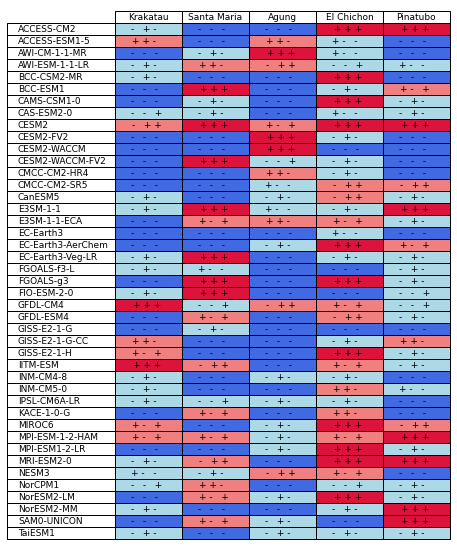

In [45]:
# produce table showing which models have positive and negative anomalies  6,12,24 months after the eruption for EA
fig, axes = plt.subplots(1)

mod_check_plot2(model_check_6mon_EA.tas, model_check_12mon_EA.tas, model_check_24mon_EA.tas, colours_tas, ax=axes)

plt.savefig('model_table_tas_EA.pdf', dpi=300, bbox_inches='tight')

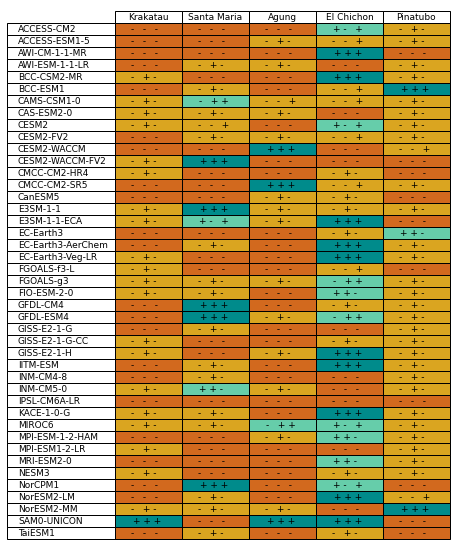

In [46]:
# produce table showing which models have positive and negative anomalies  6,12,24 months after the eruption for globe
fig, axes = plt.subplots(1)

mod_check_plot2(model_check_6mon_Glob.pr, model_check_12mon_Glob.pr, model_check_24mon_Glob.pr, colours_pr, ax=axes)

plt.savefig('model_table_pr_Glob.pdf', dpi=300, bbox_inches='tight')

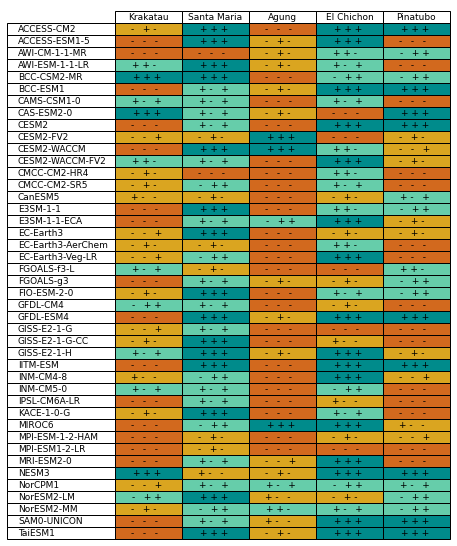

In [47]:
# produce table showing which models have positive and negative anomalies  6,12,24 months after the eruption for SH
fig, axes = plt.subplots(1)

mod_check_plot2(model_check_6mon_SH.pr, model_check_12mon_SH.pr, model_check_24mon_SH.pr, colours_pr, ax=axes)

plt.savefig('model_table_pr_SH.pdf', dpi=300, bbox_inches='tight')

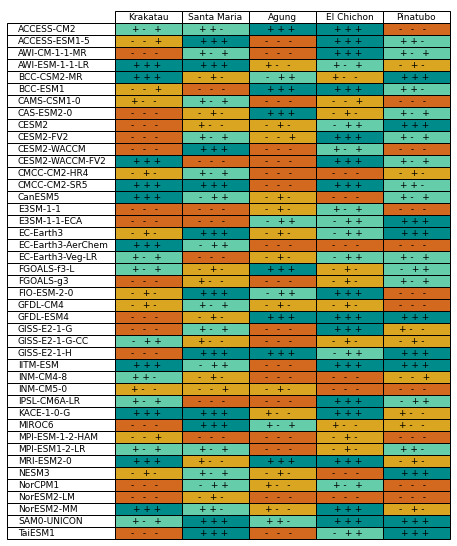

In [48]:
# produce table showing which models have positive and negative anomalies  6,12,24 months after the eruption for Aus
fig, axes = plt.subplots(1)

mod_check_plot2(model_check_6mon_Aus.pr, model_check_12mon_Aus.pr, model_check_24mon_Aus.pr, colours_pr, ax=axes)

plt.savefig('model_table_pr_Aus.pdf', dpi=300, bbox_inches='tight')

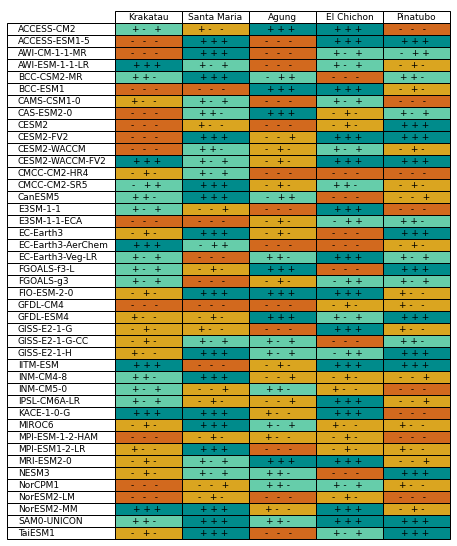

In [49]:
# produce table showing which models have positive and negative anomalies  6,12,24 months after the eruption for EA
fig, axes = plt.subplots(1)

mod_check_plot2(model_check_6mon_EA.pr, model_check_12mon_EA.pr, model_check_24mon_EA.pr, colours_pr, ax=axes)

plt.savefig('model_table_pr_EA.pdf', dpi=300, bbox_inches='tight')